In [1]:
#Importing necessary files
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import pathlib
import os
import matplotlib.pyplot as plt

from keras import models, layers
from keras.layers import Conv2D, MaxPool2D, Dropout, Dense, Flatten, BatchNormalization, MaxPooling2D
from keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten, BatchNormalization, Input, Lambda, GlobalAveragePooling2D
from tensorflow.keras.backend import repeat_elements, expand_dims, resize_images
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD,Adam

from keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications import VGG19,ResNet50
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from keras.preprocessing.image import img_to_array, array_to_img
# Other items
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, classification_report
from tensorflow.python.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

#Loading the data
from tensorflow.keras.datasets import mnist
from tensorflow.keras.datasets import cifar10

import time
print(tf.__version__)
print(keras.__version__)


2.3.0
2.4.0


In [3]:
Fdata = keras.datasets.fashion_mnist
(train_img, train_lbl), (test_img, test_lbl) = Fdata.load_data()

4423680/4422102 [==============================] - 0s 0us/step


# NOTE

The Notebook is cleaned for assignment submission to only keep the final models and does not contain the results of numerous iterations performed to achieve these results

# SIT744 Assignment 2: Efficient Training of Convolutional Neural Network 

<div class="alert-info">
    <p>Due: <strong>11:59pm 21 September 2020</strong>  (Monday)</p>

This is an <strong>individual</strong> assignment. It contributes <strong>45%</strong> to your final mark. Read the assignment instruction carefully.

<h2> What to submit </h2>

<p>
This assignment is to be completed individually and submitted to CloudDeakin. <strong>By the due date, you are required to submit the following files to the corresponding Assignment (Dropbox) in CloudDeakin</strong>:

<ol>
<li>	<strong>[YourID]_assignment2_solution.ipynp</strong>:  This is your Python notebook solution source file. </li>
<li>	<strong>[YourID]_assingment2_output.html</strong>: This is the output of your Python notebook solution <emph>exported</emph> in HTML format.</li>
<li>	Extra files needed to complete your assignment, if any (e.g., images used in your answers).</li>
</ol>
</p>

<p>
For example, if your student ID is: 123456, you will then need to submit the following files:
<ul>
<li> 123456_assignment2_solution.ipynp </li>
<li> 123456_assignment2_output.html</li>
</ul>
</p>

<h2> Warning </h2>

Some components of this assignment may involve heavy computation that runs for a long duration. Please start early to avoid missing the assignment due date.

<h2> Marking criteria </h2>

<p>
Your submission will be marked using the following criteria.

<ul>
<li> Showing good effort through completed tasks.</li>
<li> Applying deep learning theory to design suitable deep learning solutions for the tasks.</li>
<li> Critically evaluating and reflecting on the pros and cons of various design decisions.</li>
<li> Demonstrating creativity and resourcefulness in providing unique individual solutions.</li>
<li> Showing attention to details through a good quality assignment report.</li>
</ul>
</p>

<p>
Indicative weights of various tasks are provided, but the assignment will be marked by the overall quality per the above criteria.
</p>
</div>

## Task 1 Solving Fashion-MNIST with Convolutional Neural Networks

*(weight ~18%)*

In Assignment 1, you tackled the image classification problem in Fashion-MNIST. There, you used a Densely Connected Neural Network. You should now know that is not an optimal model architecture for the problem. In Assignment 2, you will apply the best practices of deep-learning computer vision to improve the image classification performance.

### Task 1.1 Revisit Fashion-MNIST classification with DNN

*(weight ~2%)*

Review your Assignment 1 solution, and reproduce the experiment here. Try to improve the model without changing the model architecture.

In [4]:
#Loading Data
train, test = keras.datasets.fashion_mnist.load_data()

#Constructing data pipeline
def pipeline(dataset):
  pics, lab = dataset
  pics = pics/255.0
  pics = pics.reshape(len(pics), 28*28)
  lab = keras.utils.to_categorical(lab.astype(np.int32))
  return tf.data.Dataset.from_tensor_slices((pics, lab))

#Batching train set
pic_batches = pipeline(train).shuffle(10000).batch(512, drop_remainder=True)

#Spliting the data for validation
pic_validation = pipeline(test).take(1000).batch(1000)
pic_test = pipeline(test).skip(1000).batch(9000)

print(pic_batches)

<BatchDataset shapes: ((512, 784), (512, 10)), types: (tf.float64, tf.float32)>


In [5]:
def plot_acc_loss(hist1, epochs):
  plt.figure(1, figsize=(12,8))  
   
 # summarize history for accuracy  
  plt.subplot(211)  
  plt.plot(hist1.history['accuracy'], label="TRAINING")
  plt.plot(hist1.history['val_accuracy'], label="VALIDATION")
  plt.fill_between(list(range(epochs)),hist1.history['accuracy'], hist1.history['val_accuracy'], 
                  label='GENERALIZATION GAP', color='blue', alpha=.15)
  plt.title('MODEL ACCURACY')
  plt.ylabel('Accuracy')
  plt.xlabel('Epochs')
  plt.legend(['train', 'test'], loc='upper left')  
    
  # summarize history for loss  
  plt.subplot(212)  
  plt.plot(hist1.history['loss'], label="Train Loss ")
  plt.plot(hist1.history['val_loss'], label="Val Loss")
  plt.fill_between(list(range(epochs)),hist1.history['loss'], hist1.history['val_loss'], 
                  label='GENERALIZATION GAP', color='blue', alpha=.15)
  plt.title('Model Complexity Graph:  Training vs. Validation Loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validate'], loc='upper right')
  plt.show()  

#### **Old Model - SGD Optimizer**

In [ ]:
model = models.Sequential([
    Dense(20, activation='relu', input_shape=(784,)),
    Dropout(0.3),
    Dense(196, activation='relu'),
    Dropout(0.3),
    BatchNormalization(),
    Dense(392, activation='relu'),
    Dropout(0.3),
    BatchNormalization(),
    Dense(196, activation='relu'),
    Dropout(0.3),
    BatchNormalization(),
    Dense(98, activation='relu'),
    Dropout(0.3),
    Dense(49, activation='relu'),
    Dense(10, activation='softmax')])

# keras.utils.plot_model(model, show_shapes=True)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                15700     
_________________________________________________________________
dropout (Dropout)            (None, 20)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 196)               4116      
_________________________________________________________________
dropout_1 (Dropout)          (None, 196)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 196)               784       
_________________________________________________________________
dense_2 (Dense)              (None, 392)               77224     
_________________________________________________________________
dropout_2 (Dropout)          (None, 392)               0

In [ ]:
epochs = 1000
print('Training Initialed.')
model.compile(optimizer=keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),
                loss='categorical_crossentropy',
                metrics=['accuracy'])
hist1 = model.fit(pic_batches, epochs = epochs, validation_data = pic_validation,
                      verbose=0)

loss, acc = model.evaluate(pic_test)
print("Test Accuracy : {}\nTest Loss: {}".format(round(acc, 2), round(loss,2)))

Training Initialed.
1/1 [==============================] - 0s 2ms/step - loss: 0.6324 - accuracy: 0.7950
Test Accuracy : 0.8
Test Loss: 0.63


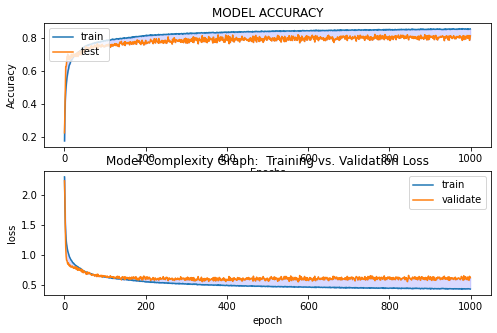

In [ ]:
plot_acc_loss(hist1, epochs)

#### New Model : Using Adagrad Optimizer

In [ ]:
model = models.Sequential([
    Dense(20, activation='relu', input_shape=(784,)),
    Dropout(0.3),
    Dense(196, activation='relu'),
    Dropout(0.3),
    BatchNormalization(),
    Dense(392, activation='relu'),
    Dropout(0.3),
    BatchNormalization(),
    Dense(196, activation='relu'),
    Dropout(0.3),
    BatchNormalization(),
    Dense(98, activation='relu'),
    Dropout(0.3),
    Dense(49, activation='relu'),
    Dense(10, activation='softmax')])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 20)                15700     
_________________________________________________________________
dropout_5 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 196)               4116      
_________________________________________________________________
dropout_6 (Dropout)          (None, 196)               0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 196)               784       
_________________________________________________________________
dense_9 (Dense)              (None, 392)               77224     
_________________________________________________________________
dropout_7 (Dropout)          (None, 392)              

In [ ]:
epochs = 1000
print('Training Initialed.')

model.compile(optimizer=keras.optimizers.Adagrad(learning_rate=0.01),
                loss='categorical_crossentropy',
                metrics=['accuracy'])
hist1 = model.fit(pic_batches, epochs = epochs, validation_data = pic_validation, verbose=0)
loss, acc = model.evaluate(pic_test)
print("Test Accuracy : {}\nTest Loss: {}".format(round(acc, 2), round(loss,2)))

Training Initialed.
1/1 [==============================] - 0s 3ms/step - loss: 0.5850 - accuracy: 0.8043
Test Accuracy : 0.8
Test Loss: 0.58


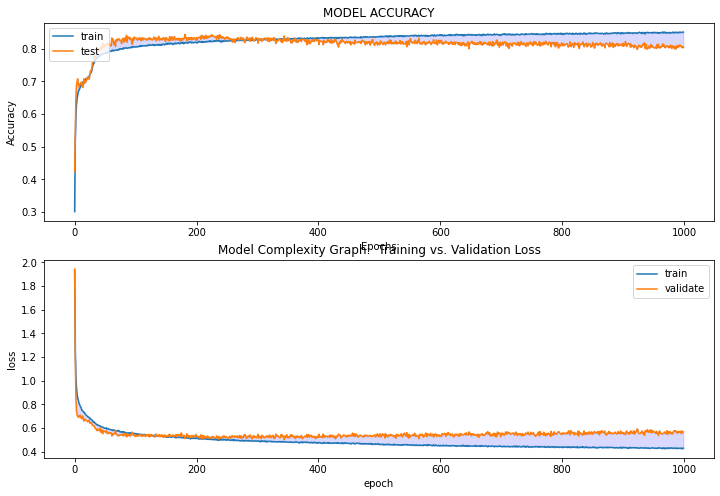

In [ ]:
plot_acc_loss(hist1, epochs)

#### **Task 1.1 - Explanation**

I tried to manipulate the **learning rate and the momentum parameter** of the Stochastic Gradient Descent Optimizer to improve the accuracy and loss of the previous model. But the accuracy kept decreasing. 

Finally, I decided to change the Optimizer itself and used the **Adagrad Optimizer with a learning rate of 0.01**. Then I trained the model for *1000 epochs*, which resulted in an increased  accuracy. Below is the comparison of improved results.

**Previous Model Results:**
*   Accuracy : 80%
*   Loss : 0.63

**Improved Model Results Iteration 1:**
*   Accuracy : 83%
*   Loss : 0.48

**Improved Model Results Iteration 2:**
*   Accuracy : 80%
*   Loss : 0.58

Our loss & accuracy both are showing better results in both iterations

----------------------






### Task 1.2 Train a ConvNet from scratch

*(weight ~2%)*

Build a ConvNet to replace the densely connected network in Task 1.1. Report the classification accuracy on the test set. Aim to achieve higher accuracy. 



In [6]:
def pipeline(dataset):
  pics, lab = dataset
  pics = pics/255.0
  pics = pics.reshape(len(pics), 28*28)
  # lab = keras.utils.to_categorical(lab.astype(np.int32))

  final = pd.concat([pd.DataFrame(pics), pd.DataFrame(lab)], ignore_index=False, sort=False, axis=1)
  cols = final.columns.tolist()
  cols[-1] = 'y'
  final.columns = cols
  return final

In [7]:
f_train = pipeline(train)
train_x = np.array(f_train.drop(columns=['y']))
train_y = np.array(f_train['y'])

test_val = pipeline(test)
X = np.array(test_val.drop(columns=['y']))
y = np.array(test_val['y'])
test_x, val_x, test_y, val_y = train_test_split(X, y, test_size=0.1, random_state=0)

train_y_encoded = to_categorical(train_y)
test_y_encoded = to_categorical(test_y)
val_y_encoded = to_categorical(val_y)

In [ ]:
# Create model inputs
image_shape=(28,28,1)

tr_x = np.array(train_x).reshape(train_x.shape[0],*image_shape)
te_x = np.array(test_x).reshape(test_x.shape[0],*image_shape)
va_x = np.array(val_x).reshape(val_x.shape[0],*image_shape)

In [ ]:
model = models.Sequential()

model.add(Conv2D(filters=32, kernel_size=(5,5), padding='same', activation='relu', input_shape=(28,28,1)))
model.add(Conv2D(filters=32, kernel_size=(5,5), padding='same', activation='relu',))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2), padding='same'))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2), padding='same'))
model.add(Dropout(0.35))

model.add(Flatten())
model.add(Dense(200, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)       

In [ ]:
epochs = 200
print('Training Initialed.')
model.compile(optimizer=keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),
                loss='categorical_crossentropy',
                metrics=['accuracy'])
hist1 = model.fit(tr_x, train_y_encoded, epochs=epochs, batch_size=128, validation_data=(va_x,val_y_encoded), verbose=0)

loss, acc = model.evaluate(te_x, test_y_encoded)
print("Test Accuracy : {}\nTest Loss: {}".format(round(acc, 2), round(loss,2)))

Training Initialed.
282/282 [==============================] - 1s 3ms/step - loss: 0.2217 - accuracy: 0.9399
Test Accuracy : 0.94
Test Loss: 0.22


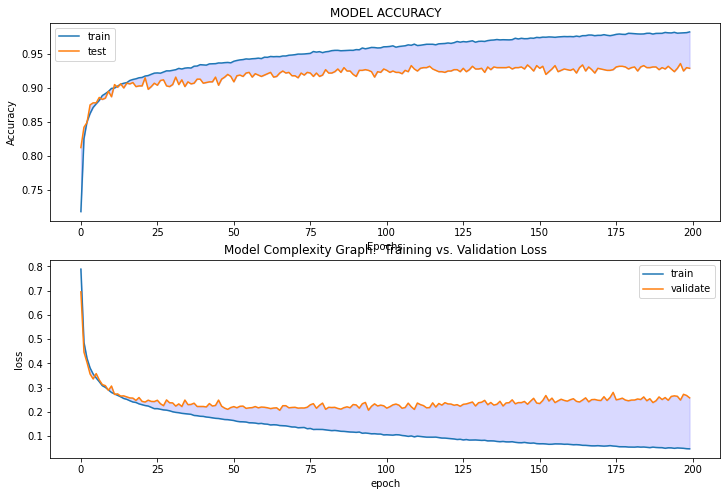

In [ ]:
plot_acc_loss(hist1, epochs)

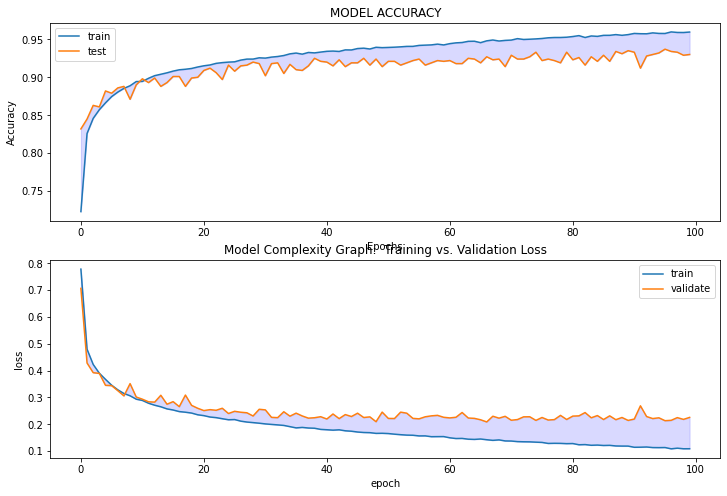

In [ ]:
plot_acc_loss(hist1, epochs)


### Task 1.3 Build an input pipeline for data augmentation

*(weight ~4%)*

Build a data preprocessing pipeline to perform data augmentation. (You may use Keras ImageDataGenerator or write your own transformations.)

- Report the new classification accuracy. Make sure that you use the same number of training epochs as in Task 1.2.

- (Optional) Profile your input pipeline to identify the most time-consuming operation. What actions have you taken to address that slow operation? (*Hint: You may use the [TensorFlow Profiler](https://github.com/tensorflow/profiler).*)

In [ ]:
model = models.Sequential()

model.add(Conv2D(filters=32, kernel_size=(5,5), padding='same', activation='relu', input_shape=(28,28,1)))
model.add(Conv2D(filters=32, kernel_size=(5,5), padding='same', activation='relu',))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2), padding='same'))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2), padding='same'))
model.add(Dropout(0.35))

model.add(Flatten())
model.add(Dense(200, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 32)        25632     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 14, 14, 64)       

In [ ]:
aug_num = 10 
datagen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False,  
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,  
        rotation_range= 0.8,  
        zoom_range = aug_num / 100, 
        width_shift_range= aug_num / 100,  
        height_shift_range= aug_num / 100,  
        horizontal_flip=0.05,  
        vertical_flip=False )

datagen.fit(tr_x)

In [ ]:
batch_size = 128
epochs = 200
print("Training Initialized.")
model.compile(optimizer=keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),loss='categorical_crossentropy',metrics=['accuracy'])
history = model.fit_generator(datagen.flow(tr_x,train_y_encoded, batch_size=batch_size),
                              epochs = epochs, validation_data = (va_x,val_y_encoded),
                              verbose = 0, steps_per_epoch=tr_x.shape[0] // batch_size)

print("Training Complete\n")

loss, acc = model.evaluate(te_x, test_y_encoded)
print("Test Accuracy : {}\nTest Loss: {}".format(round(acc, 2), round(loss,2)))

Training Initialized.
Instructions for updating:
Please use Model.fit, which supports generators.
Training Complete

282/282 [==============================] - 1s 3ms/step - loss: 0.1758 - accuracy: 0.9391
Test Accuracy : 0.94
Test Loss: 0.18


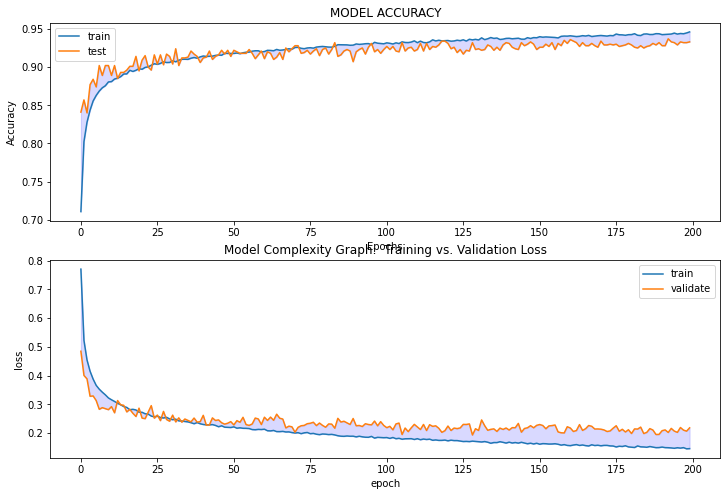

In [ ]:
plot_acc_loss(history, epochs)

### Task 1.4 Fashion-MNIST with transfer learning

*(weight ~6%)*

Use a pretrained model as the convolutional base to improve the classification performance. (Hint: You may use models in Keras Applications or those in the TensorFlow Hub.)

- Try both with fine-tuning and without fine-tuning.
- Report the model performance as before.



In [8]:
# train, test = keras.datasets.fashion_mnist.load_data()

from tensorflow.keras.datasets import fashion_mnist
train, test = keras.datasets.fashion_mnist.load_data()
from keras.applications.vgg16 import preprocess_input


In [9]:
train, test = keras.datasets.fashion_mnist.load_data()

f_train = pipeline(train)
train_x = np.array(f_train.drop(columns=['y']))
train_y = np.array(f_train['y'])

test_val = pipeline(test)
X = np.array(test_val.drop(columns=['y']))
y = np.array(test_val['y'])
test_x, val_x, test_y, val_y = train_test_split(X, y, test_size=0.1, random_state=0)

train_x = pd.DataFrame(train_x)
test_x = pd.DataFrame(test_x)
val_x = pd.DataFrame(val_x)

train_y_encoded = to_categorical(train_y)
test_y_encoded = to_categorical(test_y)
val_y_encoded = to_categorical(val_y)

X_train_tfd = train_x.values.reshape(train_x.shape[0], 28, 28)
X_test_tfd = test_x.values.reshape(test_x.shape[0], 28, 28)
X_val_tfd = val_x.values.reshape(val_x.shape[0], 28, 28)

X_train_tfd = np.repeat((X_train_tfd / X_train_tfd.max()).astype("float32")[..., np.newaxis], 3, -1)
X_test_tfd = np.repeat((X_test_tfd / X_test_tfd.max()).astype("float32")[..., np.newaxis], 3, -1)
X_val_tfd = np.repeat((X_val_tfd / X_val_tfd.max()).astype("float32")[..., np.newaxis], 3, -1)

print(X_train_tfd.shape)
print(X_test_tfd.shape)
print(X_val_tfd.shape)

(60000, 28, 28, 3)
(9000, 28, 28, 3)
(1000, 28, 28, 3)


In [10]:
# from random_eraser import get_random_eraser
datagen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False,  
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,  
        rotation_range= 0,   
        width_shift_range= 0.1,  
        height_shift_range= 0.1,  
        horizontal_flip=True,  
        vertical_flip=False )

In [11]:
def build_model(): 
    input_image = Input(shape=(28, 28, 3))
    resized_image = Lambda(lambda image: resize_images(x=image, height_factor=2, width_factor=2, data_format='channels_last'))(input_image)

    base_model = MobileNet(weights='imagenet', include_top=False, input_tensor=resized_image)

    x = base_model.output
    x = Dropout(0.5)(x)
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(10, activation='softmax')(x)

    model = models.Model(inputs=base_model.input, outputs=predictions)
    return model

model = build_model()
model.summary()

17227776/17225924 [==============================] - 1s 0us/step
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 3)]       0         
_________________________________________________________________
lambda (Lambda)              (None, 56, 56, 3)         0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 57, 57, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 28, 28, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 28, 28, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 28, 28, 32)        0         
_______________________________________________________

In [12]:
batch_size = 128
epochs = 50

**Stochastic Gradient Descent Optimizer with Data Augmentation**

In [ ]:
print("Training Initialized.")
model.compile(optimizer=keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),loss='categorical_crossentropy',metrics=['accuracy'])
history = model.fit(datagen.flow(X_train_tfd,train_y_encoded, batch_size=batch_size),
                              epochs = epochs, validation_data=(X_val_tfd, val_y_encoded),
                              verbose = 0, steps_per_epoch=X_train_tfd.shape[0] // batch_size)

print("Training Complete\n")
loss, acc = model.evaluate(X_test_tfd, test_y_encoded)
print("Test Accuracy : {}\nTest Loss: {}".format(round(acc, 2), round(loss,2)))

Training Initialized.
Training Complete

282/282 [==============================] - 1s 4ms/step - loss: 0.1916 - accuracy: 0.9463
Test Accuracy : 0.95
Test Loss: 0.19


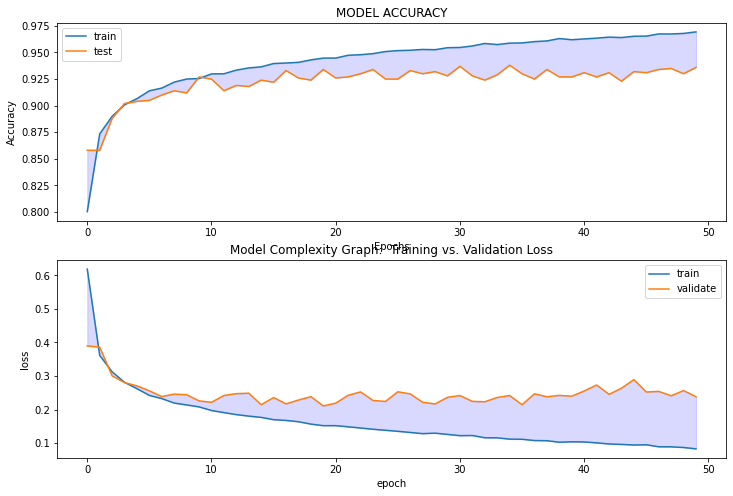

In [ ]:
plot_acc_loss(history, epochs)

**Stochastic Gradient Descent Optimizer without Data Augmentation**

In [ ]:
print("Training Initialized.")
model.compile(optimizer=keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),loss='categorical_crossentropy',metrics=['accuracy'])
history = model.fit(X_train_tfd,train_y_encoded,
                              epochs = epochs, validation_data=(X_val_tfd, val_y_encoded),
                              verbose = 0, steps_per_epoch=X_train_tfd.shape[0] // batch_size)

print("Training Complete\n")
loss, acc = model.evaluate(X_test_tfd, test_y_encoded)
print("Test Accuracy : {}\nTest Loss: {}".format(round(acc, 2), round(loss,2)))

Training Initialized.
Training Complete

282/282 [==============================] - 1s 4ms/step - loss: 0.3762 - accuracy: 0.9382
Test Accuracy : 0.94
Test Loss: 0.38


**ADAM Optimizer Transfer Learning with Data Augmentation**

In [ ]:
print("Training Initialized.")
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
history = model.fit(datagen.flow(X_train_tfd,train_y_encoded, batch_size=batch_size),
                              epochs = epochs, validation_data=(X_val_tfd, val_y_encoded),
                              verbose = 0, steps_per_epoch=X_train_tfd.shape[0] // batch_size)

print("Training Complete\n")
loss, acc = model.evaluate(X_test_tfd, test_y_encoded)
print("Test Accuracy : {}\nTest Loss: {}".format(round(acc, 2), round(loss,2)))

Training Initialized.
Training Complete

282/282 [==============================] - 1s 5ms/step - loss: 0.2061 - accuracy: 0.9417
Test Accuracy : 0.94
Test Loss: 0.21


**With Fine Tuning - Freezing Layers**

In [13]:
model = build_model()

for layer in model.layers[:-4]:
    layer.trainable = False

# # Check the trainable status of the individual layers
# for layer in model.layers:
#     print(layer, layer.trainable)

In [14]:
epochs = 200

In [15]:
print("Training Initialized.")
model.compile(optimizer=keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),loss='categorical_crossentropy',metrics=['accuracy'])

history = model.fit(datagen.flow(X_train_tfd,train_y_encoded, batch_size=batch_size),
                              epochs = epochs, validation_data=(X_val_tfd, val_y_encoded),
                              verbose = 0, steps_per_epoch=X_train_tfd.shape[0] // batch_size)

print("Training Complete\n")
loss, acc = model.evaluate(X_test_tfd, test_y_encoded)
print("Test Accuracy : {}\nTest Loss: {}".format(round(acc, 2), round(loss,2)))

Training Initialized.
Training Complete

282/282 [==============================] - 3s 11ms/step - loss: 1.7881 - accuracy: 0.4307
Test Accuracy : 0.43
Test Loss: 1.79


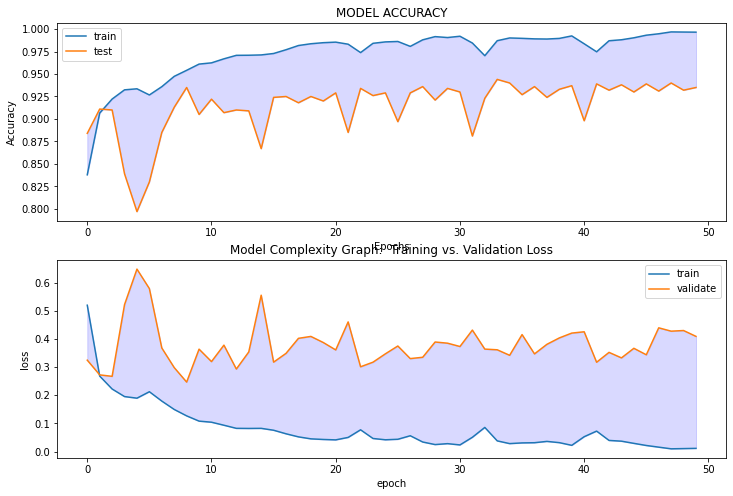

In [ ]:
plot_acc_loss(history, 50)

### Task 1.5 Performance comparison

*(weight ~4%)*

Record the test accuracy achieved at different training configurations above. Which method achieved the highest accuracy? Why did it work better for this problem?


**1. Fashion-MNIST with Data Augmentation**

- Test Accuracy: 94%
- Test Loss:  0.18
- Epochs: 200

**2. Fashion-MNIST with Transfer Learning - SGD Optimizer**

*With Data Augmentation* 
- Test Accuracy: 95%
- Test Loss:  0.19
- Epochs: 50

*Without Data Augmentation*
- Test Accuracy: 94%
- Test Loss:  0.38
- Epochs: 50

**3. Fasion MNIST with Fine Tuning (layers Freeze) & SGD Optimizer**

*Without Data Augmentation*
- Test Accuracy: 43%
- Test Loss:  1.79
- Epochs: 50

**4. Fashion MNIST with Data Augmentation - Adam Optimizer**

*With Data Augmentation* 
- Test Accuracy: 94%
- Test Loss:  0.21
- Epochs: 50

Therefore, in my opinion, Transfer Learning with Data Augmentation provided the most promising results even though the training time with transfer learning is more than the model we built ourselves. But, at the same time, transfer learning requires less number of epochs to train.

In our example, we only trained the transfer learning model for 50 epochs and we managed to get a better accuracy than our own model which we trained for 200+ epochs


-------------

## Task 2 Fast training of deep networks

*(weight ~16%)*

#### Task 2.1 Train a highly accurate network for CIFAR10

*(weight ~6%, each subquestion worths ~2%)*

In this task, you will train deep neural networks on the [CIFAR10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html). Compared with the datasets that you have worked on so far, CIFAR10 represents a relatively larger multi-class classification problem and presents a great opportunity for you to solve a "harder" problem.



##### Task 2.1.1 Document the hardware used

Before you start, write down your hardware specifications, including 

- the GPU model, the number of GPUs, and the GPU memory
- the CPU model, the number of CPUs, and the CPU clock speed

(Hint: you may find commands like `nvidia-smi`, `lscpu` or `psutil` useful.)

In [ ]:
!nvidia-smi

Tue Sep 29 07:20:40 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   74C    P0    77W / 149W |    134MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

##### Task 2.1.2 Train a "shallow" ConvNet

Build a ConvNet with fewer than 10 layers. Train the network until it converges. You will use this network as a baseline for the later experiments. 

- Plot the training and validation history. 
- Report the testing accuracy. 

In [ ]:
(x_train,y_train),(x_test,y_test) = cifar10.load_data() #load cifar 10 dataset from keras
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)


170500096/170498071 [==============================] - 6s 0us/step
(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


**Preprocessing**

In [ ]:
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

no_of_classes = len(np.unique(y_train))
no_of_classes

y_train = to_categorical(y_train,no_of_classes)
y_test = to_categorical(y_test,no_of_classes)

x_train,x_valid = x_train[5000:],x_train[:5000]
y_train,y_valid = y_train[5000:],y_train[:5000]

print(x_train.shape, y_train.shape, x_valid.shape, y_valid.shape)

(45000, 32, 32, 3) (45000, 10) (5000, 32, 32, 3) (5000, 10)


**Visualizing Data**

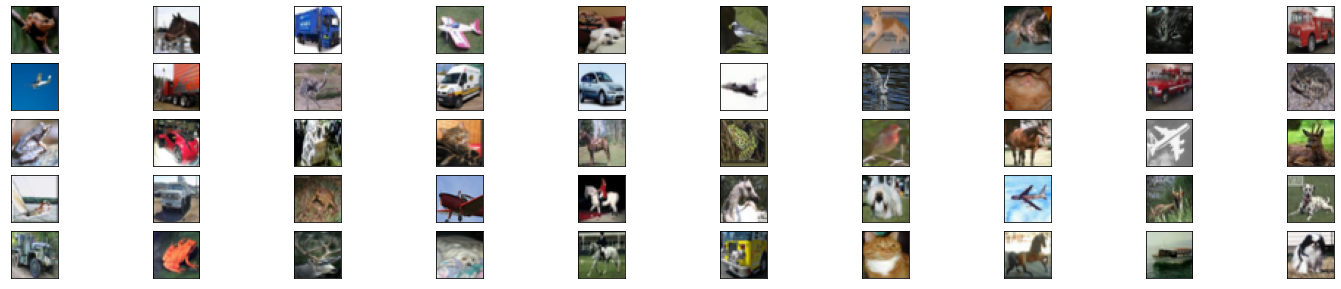

In [ ]:
fig = plt.figure(figsize=(25,5))
for i in range(50):
    ax = fig.add_subplot(5,10,i+1,xticks=[],yticks=[])
    ax.imshow(np.squeeze(x_train[i]))
    

**Model Architecture**

In [ ]:
model = models.Sequential()
model.add(Conv2D(filters=16, kernel_size = (2,2), padding = 'same',activation = 'relu',input_shape=(32,32,3)))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=32, kernel_size = (3,3), padding = 'same',activation = 'relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=64, kernel_size = (3,3), padding = 'same',activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(500,activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(10,activation='softmax'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 32, 32, 16)        208       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 16, 16, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 8, 8, 64)          18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 4, 4, 64)         

In [ ]:
model.compile(optimizer=keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),loss='categorical_crossentropy',metrics=['accuracy'])
print('compiled!')

compiled!


In [ ]:
# start training
epochs = 100
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=7,
    verbose=1,
    mode='auto')

print("Model Training has Started")

history = model.fit(x_train,y_train,batch_size=256, epochs = epochs,
          validation_data=(x_valid,y_valid),
          callbacks=early_stopping,
          verbose=0, shuffle=True)


print("Model has converged")

Model Training has Started
Epoch 00068: early stopping
Model has converged


In [ ]:
model.evaluate(x_test, y_test)[1]

313/313 [==============================] - 1s 3ms/step - loss: 0.7050 - accuracy: 0.7642


0.76419997215271

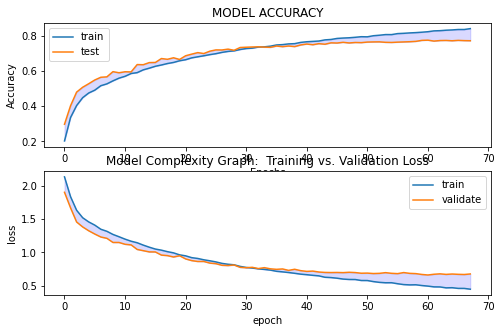

In [ ]:
plot_acc_loss(history, 68)

#### Task 2.1.3 Train a ResNet

Train a residual neural network (ResNet) on the CIFAR10 training data and report the test accuracy and the training time.

The ResNet is a popular network architecture for image classification. You may find more information about how ResNet works by reading this [paper](https://arxiv.org/abs/1512.03385).


*(You may implement a resnet model or use an existing implementation. In either case, you should not use pretrained network weights.)*

In [ ]:
(x_train,y_train),(x_test,y_test)=cifar10.load_data()

x_train,x_val,y_train,y_val= train_test_split(x_train,y_train,test_size=.1)

print((x_train.shape,y_train.shape))
print((x_val.shape,y_val.shape))
print((x_test.shape,y_test.shape))

170500096/170498071 [==============================] - 6s 0us/step
((45000, 32, 32, 3), (45000, 1))
((5000, 32, 32, 3), (5000, 1))
((10000, 32, 32, 3), (10000, 1))


In [ ]:
y_train=to_categorical(y_train)
y_val=to_categorical(y_val)
y_test=to_categorical(y_test)

print((x_train.shape,y_train.shape))
print((x_val.shape,y_val.shape))
print((x_test.shape,y_test.shape))

((45000, 32, 32, 3), (45000, 10))
((5000, 32, 32, 3), (5000, 10))
((10000, 32, 32, 3), (10000, 10))


##### **Initial ResNet Model**

We are defining the intial Resnet Model here for training and analyzing how our model is performing in order make the required changes in the final model. We will use Early Stopping to stop the model training when the training when the validation accuracy stops deacreasing.

The parameter that we'll use for the model are:
- batch_size : 128
- epochs : 50
- optimizer : Stochastic Gradient Descent (SGD) with momentum or Adam
- learning rate : 0.01

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=3,
    verbose=1,
    mode='auto')

batch_size= 128
epochs=50
learn_rate=.01
sgd=SGD(lr=learn_rate,momentum=.9,nesterov=False)
adam=Adam(lr=learn_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

##### **Defining Model Architecture**

In [ ]:
def build_resnet():
  resnet50 = ResNet50(include_top=False,input_shape=(32,32,3),classes=y_train.shape[1], weights = None)

  model = models.Sequential()
  model.add(resnet50)
  model.add(Flatten())

  model.add(Dense(4000, activation=('relu'), input_dim=512))
  model.add(Dense(2000, activation=('relu')))
  model.add(Dropout(0.35))

  model.add(Dense(1000, activation=('relu')))
  model.add(Dropout(0.35))
  model.add(Dense(500, activation=('relu')))
  model.add(Dropout(0.20))
  model.add(Dense(10, activation=('softmax')))

  return model

##### **Model Training - test iteration SGD optimizer**


In [ ]:
model = build_resnet()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 1, 1, 2048)        23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 4000)              8196000   
_________________________________________________________________
dense_6 (Dense)              (None, 2000)              8002000   
_________________________________________________________________
dropout_3 (Dropout)          (None, 2000)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 1000)              2001000   
_________________________________________________________________
dropout_4 (Dropout)          (None, 1000)             

In [ ]:
print("Model Training Initialized")

model.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy'])
s_time = time.time()
history = model.fit(x_train,y_train,batch_size=batch_size, epochs = epochs,
          validation_data=(x_val,y_val),
          callbacks=early_stopping,
          verbose=0, shuffle=True)

f_time = time.time() - s_time

print("Model Training Finished")
print("Total Training Time: ", round(f_time, 3))

Model Training Initialized
Epoch 00032: early stopping
Model Training Finished
Total Training Time:  814.89


In [ ]:
loss, acc = model.evaluate(x_test, y_test)
print("Test Accuracy : {}\nTest Loss: {}".format(round(acc, 2), round(loss,2)))


313/313 [==============================] - 3s 10ms/step - loss: 1.2412 - accuracy: 0.7820
Test Accuracy : 0.78
Test Loss: 1.24


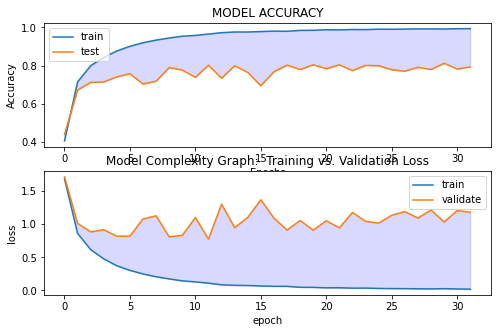

In [ ]:
plot_acc_loss(history, 32)

##### **Model Training - test iteration Adam optimizer**

In [ ]:
model = build_resnet()
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 1, 1, 2048)        23587712  
_________________________________________________________________
flatten_8 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_31 (Dense)             (None, 4000)              8196000   
_________________________________________________________________
dense_32 (Dense)             (None, 2000)              8002000   
_________________________________________________________________
dropout_21 (Dropout)         (None, 2000)              0         
_________________________________________________________________
dense_33 (Dense)             (None, 1000)              2001000   
_________________________________________________________________
dropout_22 (Dropout)         (None, 1000)            

In [ ]:
print("Model Training Initialized")

model.compile(optimizer=adam,loss='categorical_crossentropy',metrics=['accuracy'])
s_time = time.time()
history = model.fit(x_train,y_train,batch_size=batch_size, epochs = epochs,
          validation_data=(x_val,y_val),
          callbacks=early_stopping,
          verbose=0, shuffle=True)

f_time = time.time() - s_time

print("Model Training Finished")
print("Total Training Time: ", round(f_time, 2))

Model Training Initialized
Epoch 00033: early stopping
Model Training Finished
Total Training Time:  821.58


In [ ]:
loss, acc = model.evaluate(x_test, y_test)
print("Test Accuracy : {}\nTest Loss: {}".format(round(acc, 2), round(loss,2)))


313/313 [==============================] - 3s 10ms/step - loss: 2.3031 - accuracy: 0.1000
Test Accuracy : 0.1
Test Loss: 2.3


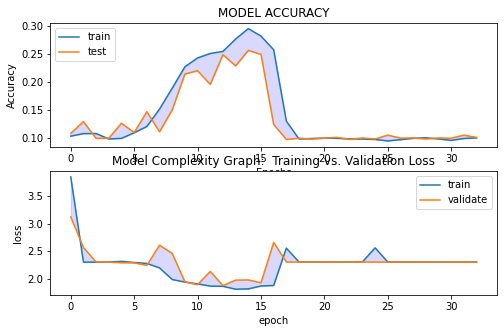

In [ ]:
plot_acc_loss(history, 33)

###### **Optimizer Choise**
We can see that Adam optimizer performs drastically bad at training therefore, we are going to use Stochastic Gradient Descent Optimizer! 

##### **Final Resnet Model with Data Augmentation**
We will now improve our base model and add few other improvements to it so ensure better accuracy and loss. Additionally, we are going to incorporate *Data Augmentation* to our model as well


**Data Augmentation**

In [ ]:
aug_num = 10 


train_generator = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False,  
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,  
        rotation_range= 0.8,  
        zoom_range = aug_num / 100, 
        width_shift_range= aug_num / 100,  
        height_shift_range= aug_num / 100,  
        horizontal_flip=0.05,  
        vertical_flip=False )

val_generator = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False,  
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,  
        rotation_range= 0.8,  
        zoom_range = aug_num / 100, 
        width_shift_range= aug_num / 100,  
        height_shift_range= aug_num / 100,  
        horizontal_flip=0.05,  
        vertical_flip=False )

test_generator = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False,  
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,  
        rotation_range= 0.8,  
        zoom_range = aug_num / 100, 
        width_shift_range= aug_num / 100,  
        height_shift_range= aug_num / 100,  
        horizontal_flip=0.05,  
        vertical_flip=False )

train_generator.fit(x_train)
val_generator.fit(x_val)
test_generator.fit(x_test)

In [ ]:
batch_size= 128
epochs=50

learn_rate=.01

sgd=SGD(lr=learn_rate,momentum=.9,nesterov=False)
adam=Adam(lr=learn_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

In [ ]:
model = build_resnet()

In [ ]:
print("Model Training Initialized")
model.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy'])
s_time = time.time()
history = model.fit(train_generator.flow(x_train,y_train,batch_size=batch_size), 
            epochs=50,
            steps_per_epoch=int( np.ceil(x_train.shape[0] // batch_size) ),
            validation_data=val_generator.flow(x_val,y_val,batch_size=batch_size),
            validation_steps=int( np.ceil(x_val.shape[0] // batch_size) ),
            verbose=0)

f_time = time.time() - s_time
print("Model Training Finished\n")
print("Total Training Time: ", round(f_time, 2))

Model Training Initialized
Model Training Finished

Total Training Time:  1361.97


In [ ]:
loss, acc = model.evaluate( test_generator.flow(x_test,y_test,batch_size=batch_size))
print("Test Accuracy : {}\nTest Loss: {}".format(round(acc, 2), round(loss,2)))

79/79 [==============================] - 5s 61ms/step - loss: 0.8421 - accuracy: 0.7838
Test Accuracy : 0.78
Test Loss: 0.84


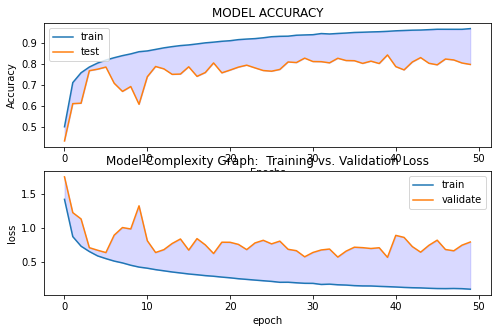

In [ ]:
plot_acc_loss(history, 50)

### Task 2.2 Fast training of ResNet

*(weight ~5%)*

In this task, you will experiment with different ways to reduce the time for training your ResNet on CIFAR10. There are different ways to speed up neural network training; below are two ideas. Please select at least one idea to implement. Explain the experiment steps and report the final performance and training time.

#### Option 1. Learning rate schedule

Use a learning rate schedule for the training. Some popular learning rate schedules include 

- the Step Decay learning rate (e.g., see [here](https://github.com/kuangliu/pytorch-cifar))
- [Cyclical learning rates](https://arxiv.org/abs/1506.01186)
- [The exponential learning rate](https://openreview.net/forum?id=rJg8TeSFDH) 

Also Keras provides [some convenient functions](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules) that you can use.


#### Option 2. Look ahead optimiser

Read [this paper](https://arxiv.org/abs/1907.08610) and implement the Lookahead optimiser.

**Learning Rate Annealer**

In [ ]:
batch_size= 128
epochs=50

learn_rate=.01

sgd=SGD(lr=learn_rate,momentum=.9,nesterov=False)

lrr= ReduceLROnPlateau(
                       monitor='val_loss', 
                       factor=.01, 
                       patience=3, 
                       min_lr=1e-5) 




In [ ]:
model = build_resnet()

##### **Resnet Training with ReduceLROnPlateau Scheduler**

In [ ]:
print("Model Training Initialized")
model.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy'])
s_time = time.time()
history = model.fit(train_generator.flow(x_train,y_train,batch_size=batch_size), 
            epochs=50,
            steps_per_epoch=int( np.ceil(x_train.shape[0] // batch_size) ),
            validation_data=val_generator.flow(x_val,y_val,batch_size=batch_size),
            validation_steps=int( np.ceil(x_val.shape[0] // batch_size) ),
            callbacks=[lrr],
            verbose=0)

f_time = time.time() - s_time
print("Model Training Finished\n")
print("Total Training Time: ", round(f_time, 2))

Model Training Initialized
Model Training Finished

Total Training Time:  1362.64


In [ ]:
loss, acc = model.evaluate( test_generator.flow(x_test,y_test,batch_size=batch_size))
print("Test Accuracy : {}\nTest Loss: {}".format(round(acc, 2), round(loss,2)))

79/79 [==============================] - 5s 61ms/step - loss: 0.4938 - accuracy: 0.8336
Test Accuracy : 0.83
Test Loss: 0.49


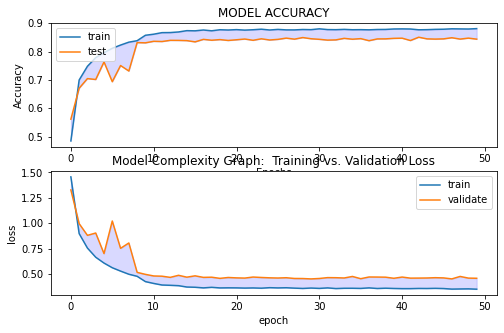

In [ ]:
plot_acc_loss(history, 50)

##### **Resnet Training with StepDecay Scheduler**

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD
from keras.callbacks import LearningRateScheduler

class LearningRateDecay:
    def plot(self, epochs, title="Learning Rate Schedule"):
      lrs = [self(i) for i in epochs]

class PolynomialDecay(LearningRateDecay):
    def __init__(self, maxEpochs=100, initAlpha=0.01, power=1.0):
      self.maxEpochs = maxEpochs
      self.initAlpha = initAlpha
      self.power = power
    def __call__(self, epoch):
      decay = (1 - (epoch / float(self.maxEpochs))) ** self.power
      alpha = self.initAlpha * decay
      return float(alpha)



In [ ]:
batch_size= 128
epochs=50
decay = 0.0

schedule = PolynomialDecay(maxEpochs=epochs, initAlpha=1e-1, power=5)
callbacks = LearningRateScheduler(schedule)

sgd = SGD(lr=1e-1, momentum=0.9, decay=decay)

In [ ]:

model = build_resnet()

94773248/94765736 [==============================] - 1s 0us/step


In [ ]:

print("Model Training Initialized")
model.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy'])
s_time = time.time()
history = model.fit(train_generator.flow(x_train,y_train,batch_size=batch_size), 
            epochs=50,
            steps_per_epoch=int( np.ceil(x_train.shape[0] // batch_size) ),
            validation_data=val_generator.flow(x_val,y_val,batch_size=batch_size),
            validation_steps=int( np.ceil(x_val.shape[0] // batch_size) ),
            callbacks=callbacks,
            verbose=0)

f_time = time.time() - s_time
print("Model Training Finished\n")
print("Total Training Time: ", round(f_time, 2))

Model Training Initialized
Model Training Finished

Total Training Time:  1302.98


In [ ]:
loss, acc = model.evaluate( test_generator.flow(x_test,y_test,batch_size=batch_size))
print("Test Accuracy : {}\nTest Loss: {}".format(round(acc, 2), round(loss,2)))

79/79 [==============================] - 5s 65ms/step - loss: 0.6146 - accuracy: 0.8014
Test Accuracy : 0.8
Test Loss: 0.61


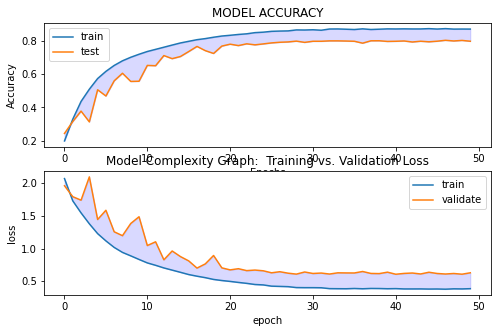

In [ ]:
plot_acc_loss(history, 50)

### Task 2.3 Performance comparison

*(weight ~5%)*

Based on the above experiments, which method or which combination of methods result in the best accuracy with the same training time.

**1. Simple Resnet Model with Data Augmentation**
- Test Accuracy: 78% 
- Test Loss: 0.84
- Training Time (50 epochs): 1361.97 Seconds 

**2. Resnet Model with ReduceLROnPlateau**
- Test Accuracy: 83%
- Test Loss: 0.49
- Training Time (50 epochs): 1362.64

**3. Resnet Model with StepDecay Scheduler**
- Test Accuracy: 80%
- Test Loss: 0.61
- Training Time (50 epochs): 1302.98

All 3 models were trained with the same configurations i.e. Optimizers, number of train, test and val samples etc. We can see that the *ReduceLROnPlateau* Secheduler resulted in the best performance. 

It is very evident that without using a learning rate scheduler, the training time is significantly more than it is with a scheduler. We trained for only 50 epochs so that we could perform multiple iterations with different parameters. Although StepDecay performed slightly faster than the ReduceLROnPlateau Scheduler, the performance of the later is more decent than StepDecay both in terms of both accuracy & loss

-----------------

## Task 3 Design a novel deep neural network model (Challenge Task for Targeting HD Grades)

*(weight ~11%)*
Here, you have to show your critical idea to design a new neural network model. We will evaluate your results based on the novelty of the model and performance of the model. 

### Task 3.1: The key idea to design a novel deep neural networks for CIFAR10

*(weight ~5%)*

In this task, you will design a novel deep neural networks on the [CIFAR10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html). CIFAR10 represents a relatively larger multi-class classification problem and presents a great opportunity for you to solve a "harder" problem. Different from Task 2, in this task you are required to design a novel neural network and optimize the performance in classification. In your answer, you have to clearly present what the key difference between your model and the classic ones, what the benefits in your design model.

### Task 3.2: The implementation of the novel deep neural networks for CIFAR10

*(weight ~6%)*

In this task, it requires you to write the codes for model implementation and report the performance. In your results, you have to demonstrate the compared performance of your new model and the state-of-the-art models.

### HD Task Solution Overview
In this HD task, I will design and develop the novel deep neural network in parallel therefore, Task 3.1 & Task 3.2 are both being performed here. I will add reasoning to why I am choosing to design my neural network in that particular manner on every iteration. 


In [ ]:
# Importing the necessary libraries, which we may or may not use. Its always good idea to import them befor (if you remember) else we can do it at any point of time no problem.
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPool2D,Dense,Flatten,Dropout,Input, AveragePooling2D, Activation,Conv2D, MaxPooling2D, BatchNormalization,Concatenate
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [ ]:
from tensorflow.keras.datasets import cifar10

(x_train, y_train), (x_test, y_test)=cifar10.load_data()

print('Shape of x_train is {}'.format(x_train.shape))
print('Shape of x_test is {}'.format(x_test.shape))
print('Shape of y_train is {}'.format(y_train.shape))
print('Shape of y_test is {}'.format(y_test.shape))

170500096/170498071 [==============================] - 44s 0us/step
Shape of x_train is (50000, 32, 32, 3)
Shape of x_test is (10000, 32, 32, 3)
Shape of y_train is (50000, 1)
Shape of y_test is (10000, 1)


In [ ]:
from tensorflow.keras.utils import to_categorical

# Normalizing
x_train=x_train/255
x_test=x_test/255

#One hot encoding
y_train_cat=to_categorical(y_train,10)
y_test_cat=to_categorical(y_test,10)

### Models
We will start with 2 basic CNN layers, where each layer is attached to a maxpool layer. Max pooling is a great way to reduce the size of parameters with out loosing much information. Asusual in any deep learning model we need to flatten the intermediate layers results and pass them to a Dense network. Then the dense network result will be passes to a final output layer where the number of units represent the number of categories in the data which is 10 in our case. Softmax is chosen as final activation because we need the highest probable class out of 10.

Finally compile your model using adam optimizer or SGD

Let us try to Sequentially build our models. Start from basic 2 convolution layers with a max pool layer after each. Slowly we will increase complexity.


#### Model 1: Base Model

two simple convolutonal layers with 32 filters each and input shape is 32*32*3 and activation will be relu

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=3,
    verbose=1,
    mode='auto')

batch_size= 128
epochs=50
learn_rate=.01

sgd=SGD(lr=learn_rate,momentum=.9,nesterov=False)

In [ ]:
model= models.Sequential()
model.add(Conv2D(filters=32,kernel_size=(4,4),input_shape=(32,32,3),activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters=32,kernel_size=(4,4),input_shape=(32,32,3),activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(10,activation='softmax'))

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
history=model.fit(x_train,y_train_cat,epochs=20,validation_data=(x_test,y_test_cat), verbose = 0)
loss, acc = model.evaluate(x_test, y_test_cat)
print("Test Accuracy : {}\nTest Loss: {}".format(round(acc, 2), round(loss,2)))

313/313 [==============================] - 1s 3ms/step - loss: 1.9008 - accuracy: 0.6597
Test Accuracy : 0.66
Test Loss: 1.9


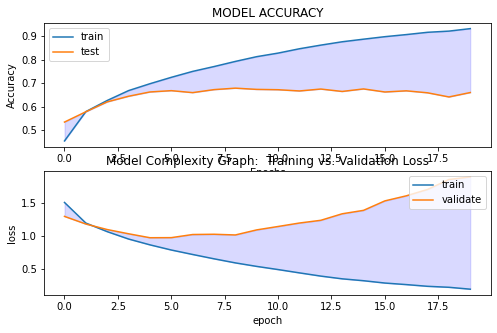

In [ ]:
plot_acc_loss(history, 20)

Using our base model we are able to get 88% training accuracy and 65% test accuracy, which is not that great but still we use very simple model. We can perform lot of tweeks to acheive pretty good accuracy. If you observe the model training log above you can see that Validation loss is increasing a lot which means our model is overfitting. 

Overfitting means our model performs good on the training data set but fails to generalize on the unseen data. Lets try to reduce overfitting.

How to reduce Overfitting? If you google how to reduce overfitting, you will probably get answers like below.

1. Add more data
2. Decrease model complexity
3. Apply regularization

Option 1 and 2 are not a good fit in our case, since getting more data is very tough and out model is not that complex to reduce the architecture. So lets regularize the model. 

Lets add Dropout to our model and see the results. Drop means we gonna drop some of the neural units randomly from our network, which forces the next layer to learn the patterns again. In this way our model will become more robust and generalizes well. Lets try to add drop out after each CNN layer + MaxPool Layer.

#### Model 2 : Add Drop out

In [ ]:
model=Sequential()
model.add(Conv2D(filters=32,kernel_size=(4,4),input_shape=(32,32,3),activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25)) # Drop 25% of the units from the layer.
model.add(Conv2D(filters=32,kernel_size=(4,4),input_shape=(32,32,3),activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(10,activation='softmax'))

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
history=model.fit(x_train,y_train_cat,epochs=20,validation_data=(x_test,y_test_cat), verbose = 0)
loss, acc = model.evaluate(x_test, y_test_cat)
print("Test Accuracy : {}\nTest Loss: {}".format(round(acc, 2), round(loss,2)))

313/313 [==============================] - 1s 2ms/step - loss: 0.8977 - accuracy: 0.7000
Test Accuracy : 0.7
Test Loss: 0.9


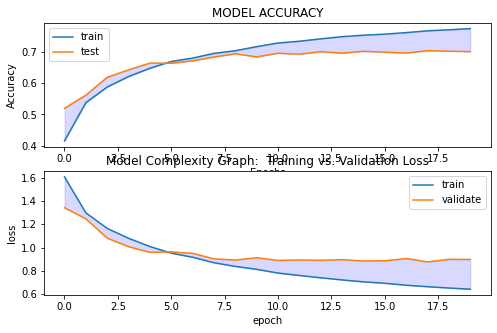

In [ ]:
plot_acc_loss(history, 20)

Thats cool, Improvememt of validation accuracy from 65 to 69.7% is a good start, lets try to add more number of layers with increase in the number of filters . Also looks like we can train out model for more number of epochs since our validation loss is in control. Thanks to drop out!!

#### Model 3 : Add More layers with more filters.

In [ ]:
model = Sequential()
model.add(Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu', input_shape = (32,32,3)))
model.add(Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPool2D(2,2))
model.add(Dropout(0.4))


model.add(Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu'))
model.add(Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPool2D(2,2))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(units = 1024, activation = 'relu'))
model.add(Dense(units = 1024, activation = 'relu'))
model.add(Dense(units = 10, activation = 'softmax'))

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
history=model.fit(x_train,y_train_cat,epochs=20,validation_data=(x_test,y_test_cat), verbose = 0)
loss, acc = model.evaluate(x_test, y_test_cat)
print("Test Accuracy : {}\nTest Loss: {}".format(round(acc, 2), round(loss,2)))

313/313 [==============================] - 1s 3ms/step - loss: 0.7553 - accuracy: 0.7678
Test Accuracy : 0.77
Test Loss: 0.76


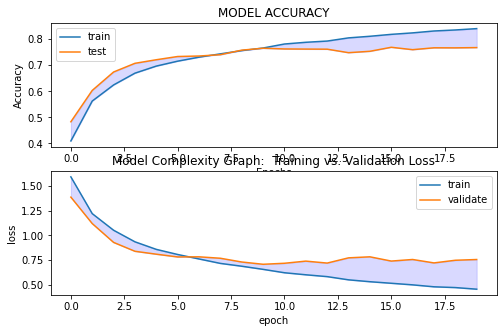

In [ ]:
plot_acc_loss(history, 20)

Adding more layers and increasing droup out from 0.25 to 0.4 resulted in 77 % accuracy which a huge improvement, so lets try increase layers. Also dont just blindly add more layers. If you keep adding more CNN's we will lose the data as data will be reduced in size due to convolution. So when we use small size images its good idea to limit the number of layers.

#### Model 4: Increased layers and Filters along with Increased dropout

In [ ]:
model = models.Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.3))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
history=model.fit(x_train,y_train_cat,epochs=50,validation_data=(x_test,y_test_cat), verbose = 0)
loss, acc = model.evaluate(x_test, y_test_cat)
print("Test Accuracy : {}\nTest Loss: {}".format(round(acc, 2), round(loss,2)))

313/313 [==============================] - 1s 3ms/step - loss: 0.6318 - accuracy: 0.7992
Test Accuracy : 0.8
Test Loss: 0.63


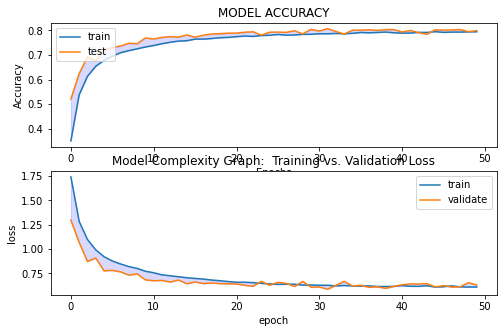

In [ ]:
plot_acc_loss(history, 50)

If you see the behaviour our model, we can still train our model longer since validation loss is not getting worse, ofcourse there are some fluctuations and distrotions in loss. Either we can run it for 200 epochs or more or simply leave it here and work on how to control those fluctuations and then train our model for more number of epochs. Lets go for option 2. 

Now the accuracy boosted to 79% from 77% which is nice. Thanks to few additional layers and also we increased drop out with the additional layers. Also you can see here we used different initializer, this I got from machine learning mastery tutorial and it works well.

#### Model 5: Adding Batch Normalization

Batch normalization works just the same way as we normalize the input data where we divided the x_train/255. What we are trying to do there is we are arranging all the features in same scale so that model converges easily and we can reduce the distrotions. Our input layer is lucky enough to have everything in same scale why not the rest of the layers? 

This is what exactly we do in batch normalization, when ever we passs the CNN throuh a batch normalization layer we are normalizing the weights so that our model will be stable and we can train model longer and also use larger learning rate.

Also the kind of normalization we use is batch normalization which means we compute mean and varience for each mini batch not the whole data.

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.3))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
history=model.fit(x_train,y_train_cat,epochs=50,validation_data=(x_test,y_test_cat), verbose = 0)
loss, acc = model.evaluate(x_test, y_test_cat)
print("Test Accuracy : {}\nTest Loss: {}".format(round(acc, 2), round(loss,2)))

313/313 [==============================] - 1s 3ms/step - loss: 0.4493 - accuracy: 0.8691
Test Accuracy : 0.87
Test Loss: 0.45


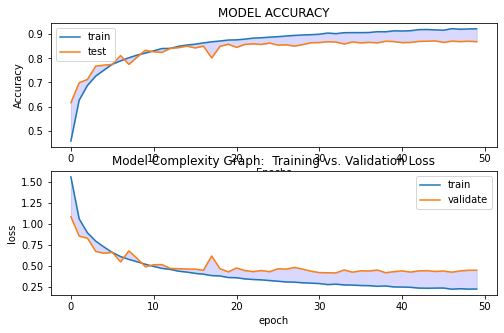

In [ ]:
plot_acc_loss(history, 50)

#### Model 6: Image augmentation

When we discussed on how to reduce overfitting we agreed that adding more data will reduce overfitting. Even when our model doesnt overfits, its very good idea to add more data if you can. But collecting data is very tough and also data preprocessing is not as fancy it sounds. But what if we can genrate data from our existing data. We already have 60K images and we can generate lots and lots of images out of it

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.3))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
history = model.fit(datagen.flow(x_train,y_train_cat), 
            epochs=200,
            steps_per_epoch=int( np.ceil(x_train.shape[0] // 64) ),
            validation_data=(x_test, y_test_cat),
            validation_steps=int( np.ceil(x_test.shape[0] // 64) ),
            verbose=0)

loss, acc = model.evaluate(x_test, y_test_cat)
print("Test Accuracy : {}\nTest Loss: {}".format(round(acc, 2), round(loss,2)))

In [ ]:
lrr= ReduceLROnPlateau(
                       monitor='val_loss', 
                       factor=.01, 
                       patience=3, 
                       min_lr=1e-5) 

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True,rotation_range=20)
it_train = datagen.flow(x_train,y_train_cat)
steps = int(x_train.shape[0] / 64)
history = model.fit_generator(it_train,
                            epochs=200,
                            steps_per_epoch=steps,
                            validation_data=(x_test,y_test_cat),
                            verbose=0)

loss, acc = model.evaluate(x_test, y_test_cat)
print("Test Accuracy : {}\nTest Loss: {}".format(round(acc, 2), round(loss,2)))

313/313 [==============================] - 1s 3ms/step - loss: 0.3570 - accuracy: 0.8836
Test Accuracy : 0.88
Test Loss: 0.36


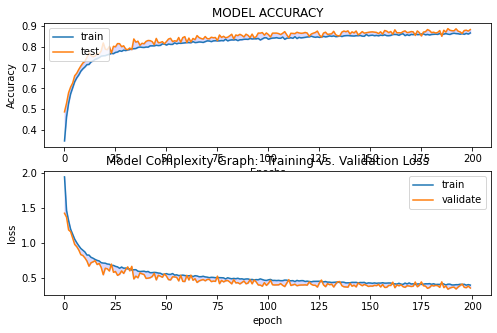

In [ ]:
plot_acc_loss(history, 200)

#### Performance Comparison

Our final model with Image Augmentation resulted in a test accuracy of 88% and 0.36 Loss. These are pretty good results considering our model has a very simple architecture compared to the other SOTA models.

The benchmark accuracy of Cifer10 dataset is 99%+, which is almost close to perfect. But considering the fact that our model has a simple architecture and simpler techniques used to improve the accuracy, the 88% accuracy is pretty good. We can see that our model is promising and with more detailing and improvements, we could potentially get closer to the SOTA accuracy as well. 



In [18]:
!jupyter nbconvert --to html final_asg.ipynb

[NbConvertApp] Converting notebook final_asg.ipynb to html
[NbConvertApp] Writing 1863293 bytes to final_asg.html
